Import Necessary Libraries: First, you'll need to import the libraries we'll be using. For image processing and machine learning, we'll use libraries like TensorFlow/Keras and OpenCV.


In [ ]:
!pip install opencv-python
#!pip install -U tensorflow

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime
import math
import pandas as pd
from tensorflow.keras.models import load_model
from tabulate import tabulate
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
def load_data(data_dir):
    images = []
    labels = []
    names = sorted(os.listdir(data_dir))
    label_map = {label: idx for idx, label in enumerate(names)}
    
    for label in names:
        label_dir = os.path.join(data_dir, label)
        for img_file in os.listdir(label_dir):
            img_path = os.path.join(label_dir, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(label_map[label])
    
    return np.array(images), np.array(labels), label_map

Load training and validation data. We split dataset into train and valid.

In [ ]:
train_dir = '/home/datascience/kaggle/new_plant_disease_dataset_augmented/new_plant_disease_dataset_augmented/train'
val_dir = '/home/datascience/kaggle/new_plant_disease_dataset_augmented/new_plant_disease_dataset_augmented/valid'

In [ ]:
X_train, y_train, label_map = load_data(train_dir)
X_val, y_val, _ = load_data(val_dir)

Normalize pixel values so that you have model learn faster and perform better

In [ ]:
X_train = X_train / 255.0
X_val = X_val / 255.0

Convert labels to one-hot encoding. So that machine algorithm understand the data

In [ ]:

y_train = to_categorical(y_train, num_classes=len(label_map))
y_val = to_categorical(y_val, num_classes=len(label_map))

Perform data augmentation

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

Build the CNN model

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])
#1 layer of convolution 2d with 32 filters 3x3 kernal size
#max pooling layer - maximum values of the feature map
#flatten turns into an array
#dense is when we feed it into the neura lnetwork
#dropout - turns off filters in layer to minimize overfitting
#dense(len) = output layer - have softmax b/c we have multiclass classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Now Set up TensorBoard and train the model

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32), 
                    steps_per_epoch=math.ceil(len(X_train) / 32), 
                    epochs=20, 
                    val_data=(X_val, y_val),
                    callbacks=[callback])

%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
model.save('/home/datascience/model/my_model')

In [ ]:

model = load_model('/home/datascience/model/my_model')


def preprocess(image_path, img_size=(128, 128)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, img_size)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img


def predict_label(image_path):
    img = preprocess(image_path)
    prediction = model.predict(img)
    predicted_label = np.argmax(prediction, axis=1)[0]
    return predicted_label


def display_image_with_label(image_path):
    predicted_label = predict_label(image_path)
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    file_name = os.path.basename(image_path)
    plt.imshow(img_rgb)
    plt.title(f"Actual File Name: {filename}\nActual Label: {actual_label}\nPredicted Label: {list(label_map.keys())[predicted_label]}", fontsize=12, y=-0.15)
    plt.axis('off')
    plt.show()
    print(f"Actual File Name: {filename}\nActual Label: {actual_label}\nPredicted Label: {list(label_map.keys())[predicted_label]}")


dp = '/home/datascience/kaggle/test/test'

results = []

########### File name containts the actual label#############
## Iterate over each image in the directory and display it with the predicted label
#for filename in os.listdir(dp):
#    if filename.endswith(".jpg"):
#        image_path = os.path.join(dp, filename)
#        predicted_label = predict_label(image_path)
#results.append((filename, {list(label_map.keys())[predicted_label]}))







# Since our test data has lots of files, we need to limit the number of displays
########### Sub directory contains the actual label#############

display_count = 0
display_limit = 8

for subdir in os.listdir(dp):
    subdir_path = os.path.join(dp, subdir)
    if os.path.isdir(subdir_path):
        actual_label = subdir
        for filename in os.listdir(subdir_path):
            if filename.endswith(".jpg"):
                image_path = os.path.join(subdir_path, filename)
                predicted_label = predict_label(image_path)
                results.append((filename, actual_label, {list(label_map.keys())[predicted_label]}))
                if display_count < display_limit:
                    display_image_with_label(image_path)
                    display_count += 1
                if display_count >= display_limit:
                    break

In [ ]:
for subdir in os.listdir(dp):
    subdir_path = os.path.join(dp, subdir)
    if os.path.isdir(subdir_path):
        actual_label = subdir
        for filename in os.listdir(subdir_path):
            if filename.endswith(".jpg"):
                image_path = os.path.join(subdir_path, filename)
                predicted_label = predict_label(image_path)
                results.append((filename, actual_label, {list(label_map.keys())[predicted_label]}))

df = pd.DataFrame(results, columns=['File Name','Actual Label', 'Predicted Label'])

#print(df)
print(tabulate(df, headers='keys', tablefmt='grid'))

In [ ]:
al = list(df["Actual Label"].tolist())
pl = list(df["Predicted Label"].tolist())

In [126]:
result_new = []

for x in range(len(al)):
    k = (al[x], set(pl[x]))
    result_new.append(k)

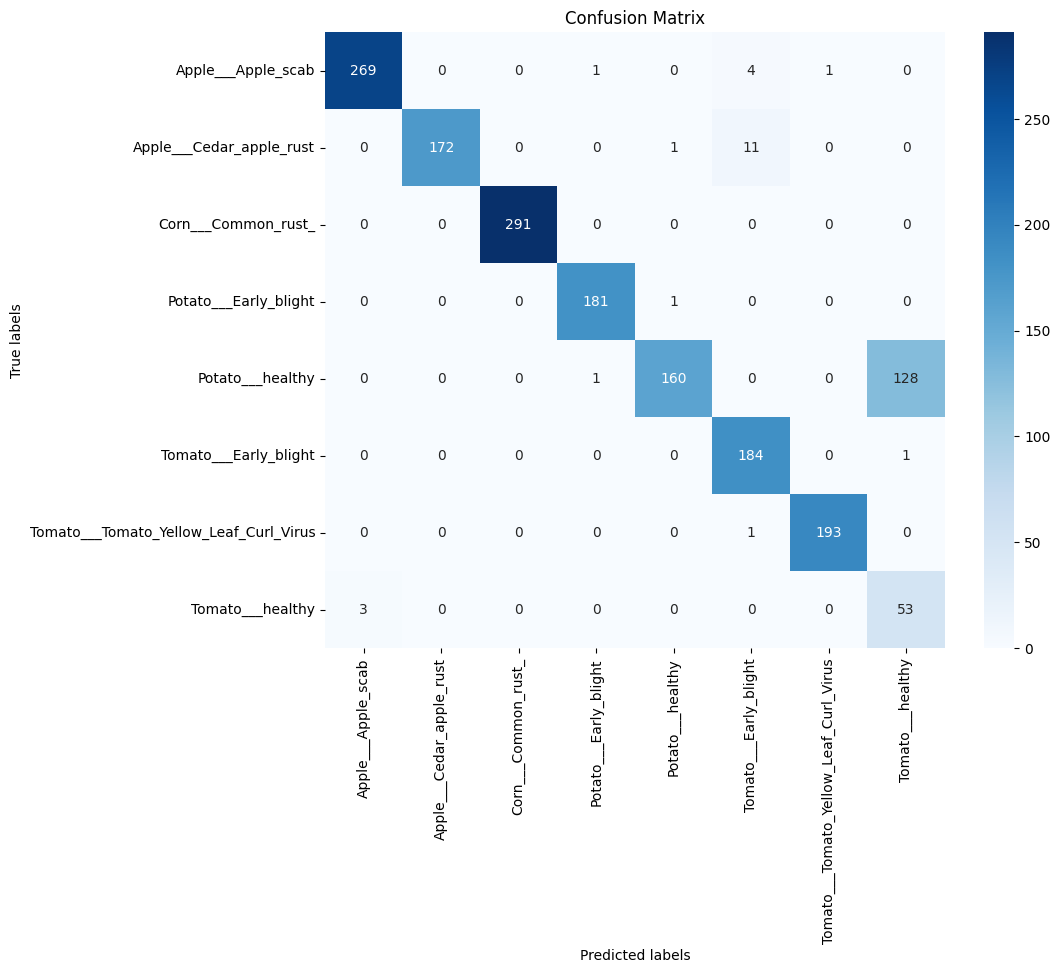

In [128]:

actual = [item[0].split('___')[0] + '___' + item[0].split('___')[1].split('.')[0] for item in result_new]
predicted = [list(item[1])[0] for item in result_new]

labels = sorted(set(actual + predicted))
cm = confusion_matrix(actual, predicted, labels=labels)

#plotting
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [131]:
plt.savefig("cm")

<Figure size 640x480 with 0 Axes>

In [ ]:
results[:10]

In [ ]:
#ONLY RUN THIS AFTER WE HAVE LABELLED THE TESTING FOLDER! THIS RENAMES ALL IMAGES TO .jpg INSTEAD OF .JPG
dp = '/home/datascience/kaggle/test/test'

all_files = os.listdir(dp)

for filename in all_files:
    if filename.endswith(".JPG"):
        old_file_path = os.path.join(dp, filename)
        new_file_path = os.path.join(dp, filename.replace(".JPG", ".jpg"))
        
        os.rename(old_file_path, new_file_path)

print("complete")


In [ ]:
#checks if any files are not in proper format 
#we need to have files in .jpg format not .JPG format in order for it to work

for f in all_files:
    if not f.endswith(".jpg"):
        print(f"Non-JPG file: {f}")
